In [2]:
import pandas as pd
import os

import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, vstack
import astropy
from astropy.coordinates import SkyCoord
import getpass

import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.afw.math as afwMath
from lsst.daf.butler import Butler
from lsst.daf.butler.registry import ConflictingDefinitionError
import lsst.geom as geom
from lsst.source.injection import ingest_injection_catalog, generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
from lsst.ip.diffim.subtractImages import AlardLuptonSubtractTask, AlardLuptonSubtractConfig

from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.base import ForcedMeasurementTask
import lsst.daf.base as dafBase
import lsst.afw.table as afwTable

In [3]:
!pwd

/pscratch/sd/t/taceroc/LE_inj


In [4]:
# repo = '/global/cfs/cdirs/lsst/production/gen3/DC2/Run2.2i/repo/butler-schema-migration.yaml'
# butler = dafPersist.Butler(repo)

# Define repo and collections

I followed some documentation:

https://github.com/LSSTDESC/ComputingInfrastructure/issues/62

https://confluence.slac.stanford.edu/spaces/LSSTDESC/pages/388840402/DC2+Data+with+the+Gen3+Butler

In [5]:
repo = '/global/cfs/cdirs/lsst/production/gen3/DC2/Run3.1i/repo'
# These are the collections containing the Y1 processed visit images, etc..
collections = ['u/descdm/sfp_ddf_visits_part_00',
               'u/descdm/sfp_ddf_visits_part_01',
              ]
# collections = ['u/jchiang8/coadds_ddf_y1-y2_4848_assembleCoadd']

## Extract calexp

In [6]:
calexp_butler = Butler(repo, collections=collections)

In [7]:
#At the moment only tracts 35, 36, 42 and 43 in patch 4848 have 2-years depth coadds. We therefore limit the dataset query to this patch.
tract = 4848
where = f"instrument='LSSTCam-imSim' AND skymap='DC2' AND \
          tract={tract} AND band='g'"
calexp_g_DatasetRefs = sorted(list(set(calexp_butler.registry.queryDatasets('calexp', where=where))))
print(f'Identified {len(calexp_g_DatasetRefs)} calexp DatasetRefs')

Identified 2103 calexp DatasetRefs


In [8]:
calexp_g_DatasetRefs[10].dataId['band']

'g'

## Select a dataset id

In [9]:
dataId = calexp_g_DatasetRefs[5].dataId
print(f"{dataId = }")

dataId = {instrument: 'LSSTCam-imSim', detector: 5, visit: 195558, band: 'g', day_obs: 20220919, physical_filter: 'g_sim_1.4'}


In [10]:
calexp = calexp_butler.get('calexp', dataId=dataId)

# Plot LE fits

In [11]:
# stamp_img_hdu = fits.open('output_file1_v2.fits')
# stamp_img_hdu = fits.open('new1.fits')
stamp_img_hdu = fits.open('fits/surface_valuesInfPlane_dt0_loop_ct165_loc[0.9, -1.3, 1, -32.6156]_dz0.06_w673_angle[30, 155].fits')
fits_img = stamp_img_hdu[0].data
stamp_img_hdu.close()

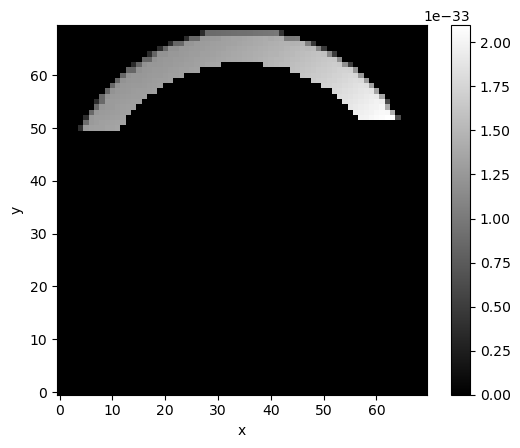

In [12]:
fig = plt.figure()
plt.subplot()
im = plt.imshow(fits_img, cmap='gray', origin='lower')
plt.colorbar(im)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [13]:
# with fits.open('output_file1.fits', mode='update') as hdul:
#     # Change something in hdul.
#     hdul[0].data = hdul[0].data - np.median(hdul[0].data)
#     # hdul.flush()
#     hdul.writeto('output_file1_median.fits')

# with fits.open('output_file1_v2.fits', mode='update') as hdul:
# #     # Change something in hdul.
#     hdul[0].data = fits_img * (fits_img < 0)
#     # hdul.flush()
#     hdul.writeto('output_file1_median.fits')

In [14]:
# stamp_img_hdu_med = fits.open('output_file1_median.fits')
# fig = plt.figure()
# plt.subplot()
# im = plt.imshow(stamp_img_hdu_med[0].data, cmap='gray', origin='lower')
# plt.colorbar(im)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()

In [15]:
calexp.getWcs()

FITS standard SkyWcs:
Sky Origin: (52.4438133835, -28.7777801320)
Pixel Origin: (2019.96, 1975.72)
Pixel Scale: 0.199844 arcsec/pixel

In [16]:
calexp.getBBox()

Box2I(corner=Point2I(0, 0), dimensions=Extent2I(4072, 4000))

In [17]:
# calexp.containsSkyCoords(53.132*u.deg, -28.398*u.deg)

In [18]:
# help(calexp.getWcs())

## Define location of LE injection on calexp

Use pixel location, then convert to radec

check that calexp contain the location

In [19]:
radec = calexp.getWcs().pixelToSky(geom.Point2D(200,200))

In [20]:
calexp.containsSkyCoords(radec.getRa().asAngularUnits(geom.degrees)*u.deg, radec.getDec().asAngularUnits(geom.degrees)*u.deg)

array([ True])

In [21]:
# radec = geom.SpherePoint(my_injection_catalog_stamp["ra"], my_injection_catalog_stamp["dec"], geom.degrees)
# xy = calexp.getWcs().skyToPixel(radec)

# Create injection catalog

I followed DP02_14_Injecting_Synthetic_Sources.ipynb

In [28]:
my_injection_catalog_stamp = Table(
    {
        'injection_id': [9999],
        'ra': [round(radec.getRa().asAngularUnits(geom.degrees),2)],
        'dec': [round(radec.getDec().asAngularUnits(geom.degrees),2)],
        'source_type': ['Stamp'],
        'mag': [24],
        'stamp': ['fits/surface_valuesInfPlane_dt0_loop_ct165_loc[0.9, -1.3, 1, -32.6156]_dz0.06_w673_angle[30, 155].fits'],
    }
)

In [22]:
os.getenv("USER")

'taceroc'

In [ ]:
# !butler remove-runs /global/cfs/cdirs/lsst/production/gen3/DC2/Run3.1i/repo u/taceroc/test_LEinjection_inputs

## Name the injection catalog collection

In [23]:
user = os.getenv("USER")
# butler remove-runs dp02 u/taceroc/test_LEinjection_inputs_2
INJECTION_CATALOG_COLLECTION = f"u/{user}/test_LEinjection_inputs_3132025"

In [ ]:
# Butler(repo, writeable=True).removeRuns(names=['u/taceroc/test_LEinjection_inputs'])

In [ ]:
writeable_butler = Butler(repo, writeable=True)

In [ ]:
# help(Butler)

## Ingest catalog

In [ ]:
try:
    my_injected_datasetRefs = ingest_injection_catalog(
        writeable_butler=writeable_butler,
        table=my_injection_catalog_stamp,
        band=dataId["band"],
        output_collection=INJECTION_CATALOG_COLLECTION,
    )
except ConflictingDefinitionError:
    print(f"Found an existing collection named INJECTION_CATALOG_COLLECTION={INJECTION_CATALOG_COLLECTION}.")
    print("\nNOTE THAT IF YOU SEE THIS MESSAGE, YOUR CATALOG WAS NOT INGESTED."
          "\nYou may either continue with the pre-existing catalog, or choose a new"
          " name and re-run the previous cell and this one to ingest a new catalog.")

In [24]:
psf = calexp.getPsf()
photo_calib = calexp.getPhotoCalib()
wcs = calexp.getWcs()

In [25]:
# calexp.mask.addMaskPlane("INJECTED")

# Read catalog

In [26]:
injection_refs = calexp_butler.registry.queryDatasets(
    "injection_catalog",
    band=dataId["band"],
    collections=INJECTION_CATALOG_COLLECTION,
)
injection_catalogs = [
    calexp_butler.get(injection_ref) for injection_ref in injection_refs
]

In [29]:
radec = geom.SpherePoint(my_injection_catalog_stamp["ra"], my_injection_catalog_stamp["dec"], geom.degrees)
xy = calexp.getWcs().skyToPixel(radec)

In [30]:
xy

Point2D(118.5837764614871, 206.84428983567045)

In [31]:
inject_config = VisitInjectConfig()

inject_task = VisitInjectTask(config=inject_config)

In [32]:
injected_output = inject_task.run(
    injection_catalogs=injection_catalogs,
    input_exposure=calexp.clone(),
    psf=psf,
    photo_calib=photo_calib,
    wcs=wcs,
)
injected_exposure = injected_output.output_exposure
injected_catalog = injected_output.output_catalog

In [33]:
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

In [34]:
xy

Point2D(118.5837764614871, 206.84428983567045)

## Plot calexp and injected calexp

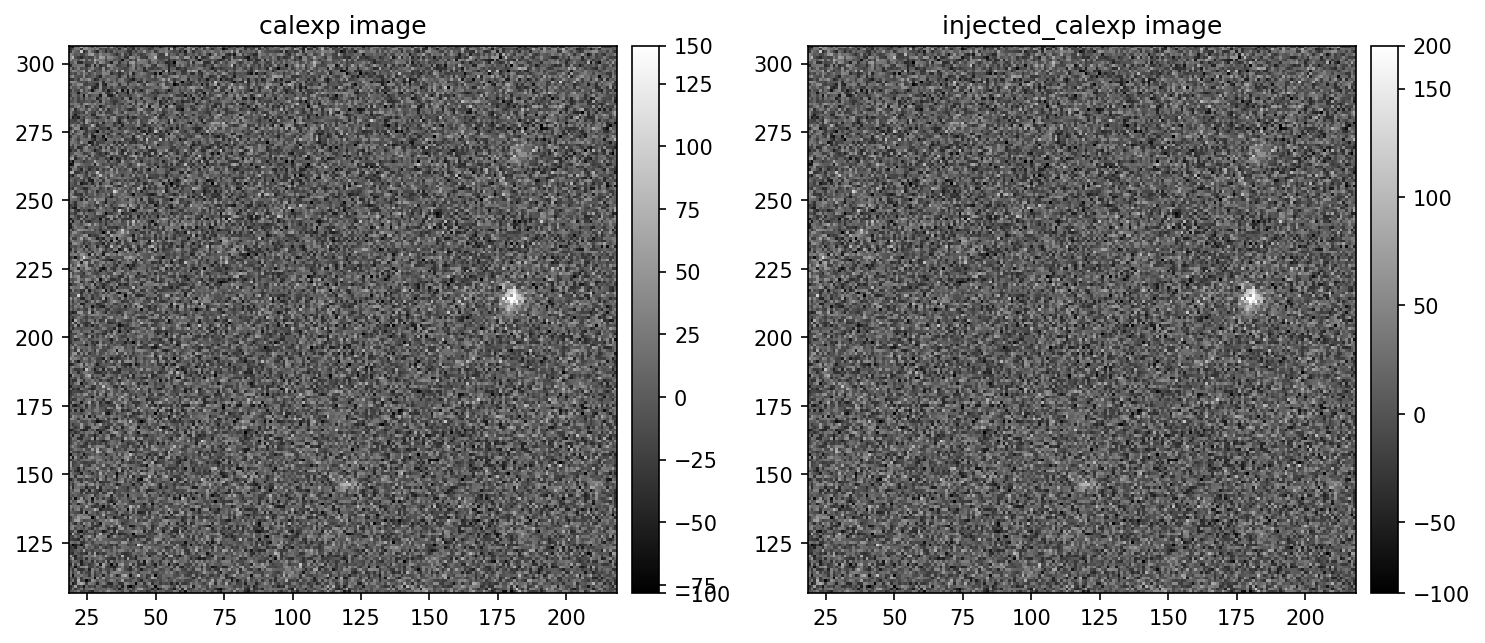

In [35]:
plot_injected_calexp = injected_exposure.clone()

fig, ax = plt.subplots(1, 2, figsize=(10, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
# display0.scale('linear', min=-20, max=150)
display0.mtv(calexp.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('calexp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
display1.mtv(plot_injected_calexp.image)
# To zoom on the PGC 038749 stamp:
display1.mtv(plot_injected_calexp.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('injected_calexp image')

plt.tight_layout()
plt.show()

In [36]:
# calexp_butler.get('goodSeeingDiff_templateExp', dataId=dataId)

# DIA for calexp, calexp

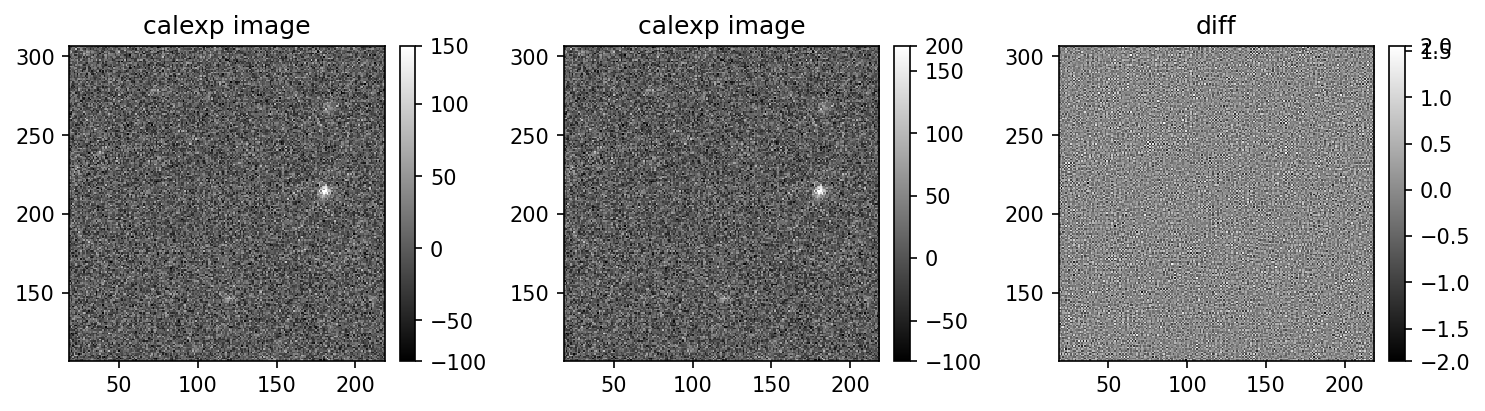

In [37]:
config = AlardLuptonSubtractConfig()
alTask = AlardLuptonSubtractTask(config=config)


sources = calexp_butler.get('src', dataId=dataId)
result = alTask.run(calexp, calexp, sources)

fig, ax = plt.subplots(1, 3, figsize=(10, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
# display0.scale('linear', min=-20, max=150)
display0.mtv(calexp.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('calexp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
display1.mtv(calexp.image)
# To zoom on the PGC 038749 stamp:
display1.mtv(calexp.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('calexp image')

plt.sca(ax[2])
display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
display2.mtv(result.difference.image)
# To zoom on the PGC 038749 stamp:
display2.mtv(result.difference.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('diff')

plt.tight_layout()
plt.show()

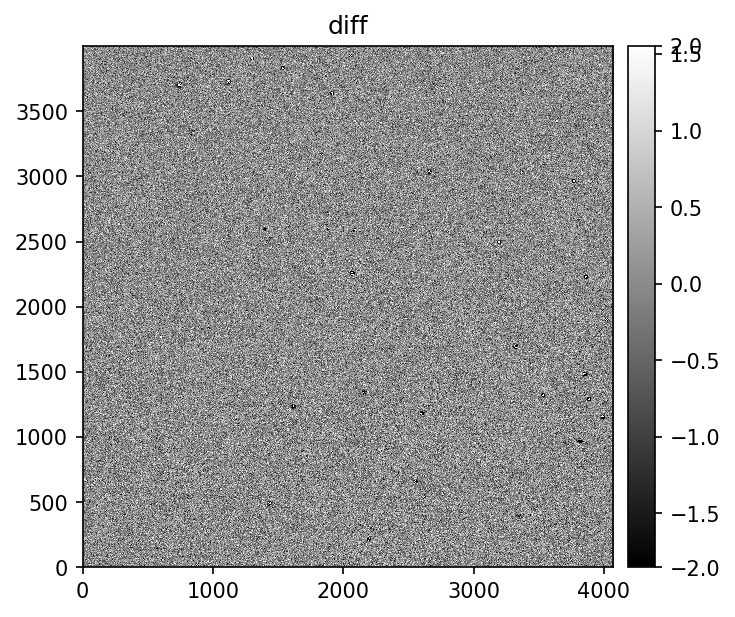

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)

display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
display2.mtv(result.difference.image)
# To zoom on the PGC 038749 stamp:
# display2.mtv(result.difference.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('diff')

plt.tight_layout()
plt.show()

In [39]:
help(result.difference.image)

Help on ImageF in module lsst.afw.image._image object:

class ImageF(ImageBaseF)
 |  Method resolution order:
 |      ImageF
 |      ImageBaseF
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  Factory(self, *args, **kwargs) from lsst.afw.image._image._slicing.supportSlicing.<locals>
 |      Return an object of this type
 |  
 |  __add__ = notImplemented(self, other) from lsst.afw.image._image._disableArithmetic.wrapNotImplemented.<locals>
 |      Provide a helpful error message about image arithmetic
 |      
 |      Unless we're operating on an ImageSlice, in which case it might be
 |      defined.
 |      
 |      Parameters
 |      ----------
 |      self : subclass of `lsst.afw.image.ImageBase`
 |          Image someone's attempting to do arithmetic with.
 |      other : anything
 |          The operand of the arithmetic operation.
 |  
 |  __deepcopy__(self, memo=None) from lsst.afw.image._image._image.Image
 |  
 |  __getit

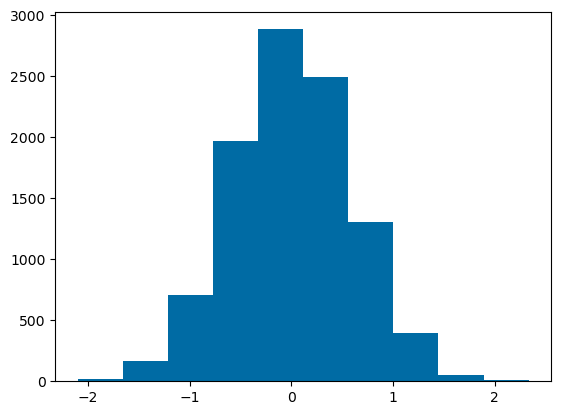

In [128]:
plt.hist(result.difference.image[xy[0]+50:xy[0]-50, xy[1]+50:xy[1]-50].getArray().flatten());

In [40]:
from scipy.signal import correlate2d

In [76]:
def autocorrelation(noise):
    """
    Calculates the autocorrelation of a noise signal.

    Args:
        noise (np.ndarray): The noise signal.

    Returns:
        np.ndarray: The autocorrelation values.
    """
    n = len(noise)
    autocorr = correlate2d(noise, noise, mode='same')
    # autocorr = autocorr[n-1:]/n # Normalize and take one side
    return autocorr

# Example usage:
# noise = np.random.randn(1000) # Generate some random noise


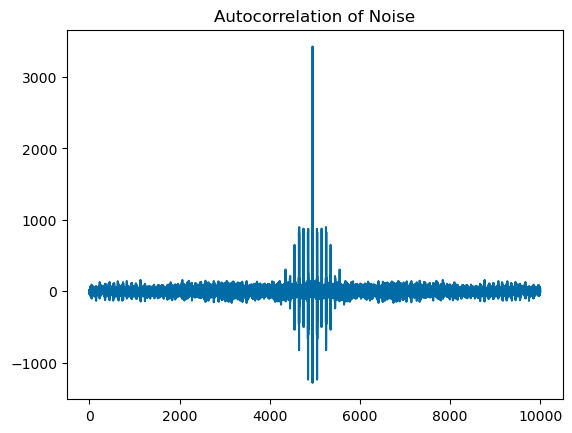

In [108]:
autocorr_values = autocorrelation(result.difference.image[xy[0]+50:xy[0]-50, xy[1]+50:xy[1]-50].getArray())
plt.plot(autocorr_values.flatten())
plt.title('Autocorrelation of Noise')
plt.show()

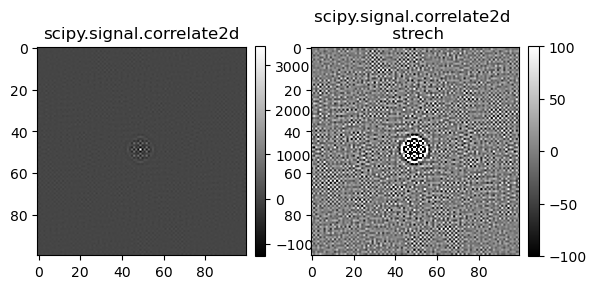

In [189]:
fig = plt.figure(figsize=(10,5))
plt.subplot(131)
img = plt.imshow(autocorr_values, cmap='gray')#, vmin=-1000, vmax=1000)
plt.colorbar(img, fraction=0.046, pad=0.04)
plt.title("scipy.signal.correlate2d")
plt.subplot(132)
img=plt.imshow(autocorr_values, cmap='gray', vmin=-100, vmax=100)
plt.title("scipy.signal.correlate2d \n strech")
plt.colorbar(img, fraction=0.046, pad=0.04)

# plt.subplot(133)
# img=plt.imshow((autocorr_values-autocorr_values.min())/(autocorr_values.max()-autocorr_values.min()), cmap='gray')#, vmin=-100, vmax=100)
# plt.title("scipy.signal.correlate2d \n minmax")
# plt.colorbar(img, fraction=0.046, pad=0.04) 
# plt.tight_layout()

0.5853722

In [116]:
def calculate_noise_power_spectrum(image):
  """Calculates the power spectrum of the noise in an image.
  The Wiener-Khinchin Theorem
  The Wiener–Khinchin theorem relates the autocorrelation function to the power spectral density via the Fourier transform:

  Args:
    image: A numpy array representing the image.

  Returns:
    A numpy array representing the power spectrum of the image noise.
  """
  noise = image - np.mean(image)
  fft_result = np.fft.fft2(noise)
  fft_shifted = np.fft.fftshift(fft_result)
  power_spectrum = np.abs(fft_shifted)**2
  return power_spectrum

# Example usage:
# Assuming 'image' is your image data as a numpy array


Text(0.5, 1.0, 'Log Power Spectrum')

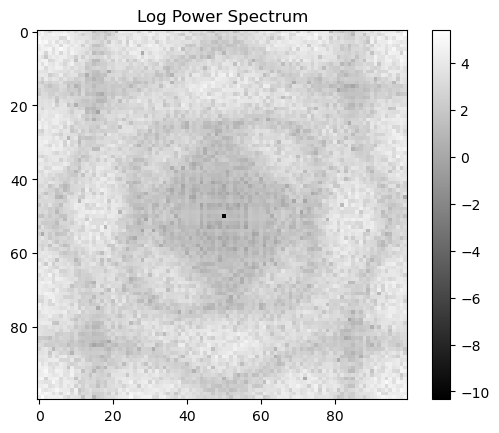

In [167]:
power_spectrum_result = calculate_noise_power_spectrum(result.difference.image[xy[0]+50:xy[0]-50, xy[1]+50:xy[1]-50].getArray())
plt.imshow(np.log10(power_spectrum_result), cmap='gray')
plt.colorbar()
plt.title("Log Power Spectrum")


In [151]:
result.difference.image[xy[0]+50:xy[0]-50, xy[1]+50:xy[1]-50].getArray().mean()

0.010426089

In [169]:
noise = np.random.normal(0.01,0.6,100*100).reshape(100,100)

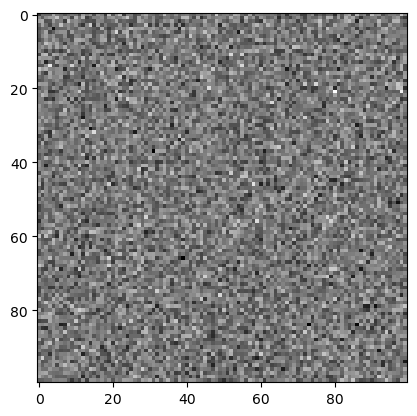

In [170]:
plt.imshow(noise, cmap='gray')

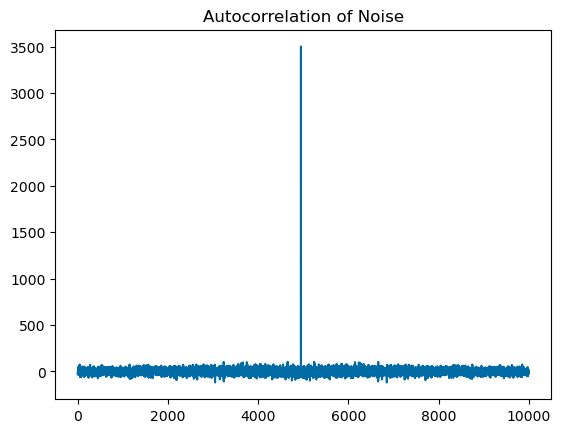

In [171]:
autocorr_values_noise = autocorrelation(noise)
plt.plot(autocorr_values_noise.flatten())
plt.title('Autocorrelation of Noise')
plt.show()

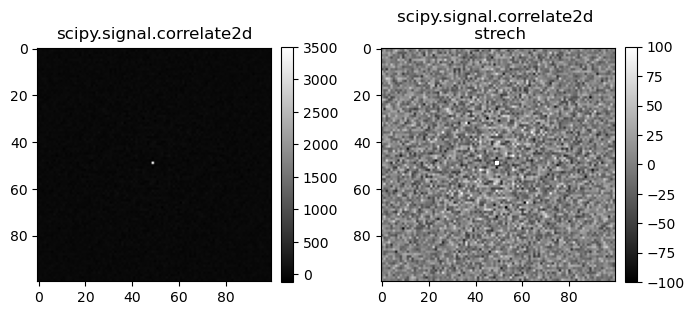

In [191]:
# plt.imshow(autocorr_values_noise, cmap='gray')#, vmin=-10, vmax=1000)
# plt.colorbar()


fig = plt.figure(figsize=(10,5))
plt.subplot(131)
img = plt.imshow(autocorr_values_noise, cmap='gray')#, vmin=-1000, vmax=1000)
plt.colorbar(img, fraction=0.046, pad=0.04)
plt.title("scipy.signal.correlate2d")
plt.subplot(132)
img=plt.imshow(autocorr_values_noise, cmap='gray', vmin=-100, vmax=100)
plt.title("scipy.signal.correlate2d \n strech")
plt.colorbar(img, fraction=0.046, pad=0.04)
plt.tight_layout()

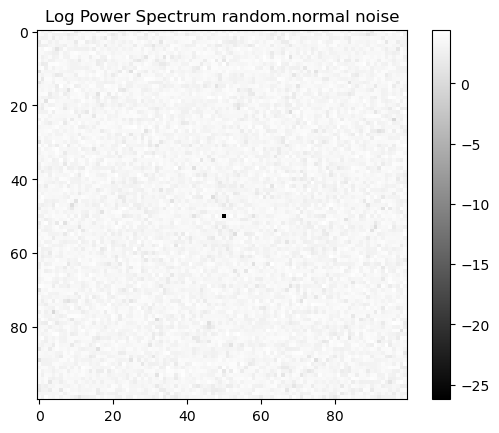

In [174]:
power_spectrum_result_noise = calculate_noise_power_spectrum(noise)
plt.imshow(np.log10(power_spectrum_result_noise), cmap='gray')#, vmin=0, vmax=1000)
plt.title("Log Power Spectrum random.normal noise")
plt.colorbar()

# DIA calexp, injected calexp

The LE is there! however LEs are always differnce images, meaning that they have this black and white colors

LE are get by comparing single images

In [ ]:
config = AlardLuptonSubtractConfig()
alTask = AlardLuptonSubtractTask(config=config)


sources = calexp_butler.get('src', dataId=dataId)
result = alTask.run(calexp, injected_exposure, sources)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
# display0.scale('linear', min=-20, max=150)
display0.mtv(calexp.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('calexp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
display1.mtv(plot_injected_calexp.image)
# To zoom on the PGC 038749 stamp:
display1.mtv(plot_injected_calexp.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('injected_calexp image')

plt.sca(ax[2])
display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
display2.mtv(result.difference.image)
# To zoom on the PGC 038749 stamp:
display2.mtv(result.difference.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('diff')

plt.tight_layout()
plt.show()

# other notebook

In [ ]:
stamp_img_hdu2 = fits.open('new2.fits')
fits_img2 = stamp_img_hdu2[0].data
stamp_img_hdu2.close()

In [ ]:
fig = plt.figure()
plt.subplot()
im = plt.imshow(fits_img2, cmap='gray', origin='lower')
plt.colorbar(im)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
my_injection_catalog_stamp = Table(
    {
        'injection_id': [9999],
        'ra': [round(radec.getRa().asAngularUnits(geom.degrees),2)],
        'dec': [round(radec.getDec().asAngularUnits(geom.degrees),2)],
        'source_type': ['Stamp'],
        'mag': [24],
        'stamp': ['new2.fits'],
    }
)
INJECTION_CATALOG_COLLECTION = f"u/{user}/test_LEinjection_inputs3"

writeable_butler = Butler(repo, writeable=True)
try:
    my_injected_datasetRefs = ingest_injection_catalog(
        writeable_butler=writeable_butler,
        table=my_injection_catalog_stamp,
        band=dataId["band"],
        output_collection=INJECTION_CATALOG_COLLECTION,
    )
except ConflictingDefinitionError:
    print(f"Found an existing collection named INJECTION_CATALOG_COLLECTION={INJECTION_CATALOG_COLLECTION}.")
    print("\nNOTE THAT IF YOU SEE THIS MESSAGE, YOUR CATALOG WAS NOT INGESTED."
          "\nYou may either continue with the pre-existing catalog, or choose a new"
          " name and re-run the previous cell and this one to ingest a new catalog.")

injection_refs = calexp_butler.registry.queryDatasets(
    "injection_catalog",
    band=dataId["band"],
    collections=INJECTION_CATALOG_COLLECTION,
)
injection_catalogs = [
    calexp_butler.get(injection_ref) for injection_ref in injection_refs
]

inject_config = VisitInjectConfig()

inject_task = VisitInjectTask(config=inject_config)

injected_output = inject_task.run(
    injection_catalogs=injection_catalogs,
    input_exposure=calexp.clone(),
    psf=psf,
    photo_calib=photo_calib,
    wcs=wcs,
)
injected_exposure2 = injected_output.output_exposure
injected_catalog2 = injected_output.output_catalog

In [ ]:
plot_injected_calexp2 = injected_exposure2.clone()

fig, ax = plt.subplots(1, 2, figsize=(10, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
# display0.scale('linear', min=-20, max=150)
display0.mtv(calexp.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('calexp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
display1.mtv(plot_injected_calexp2.image)
# To zoom on the PGC 038749 stamp:
display1.mtv(plot_injected_calexp2.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('injected_calexp image')

plt.tight_layout()
plt.show()

In [ ]:
config = AlardLuptonSubtractConfig()
alTask = AlardLuptonSubtractTask(config=config)


# sources = calexp_butler.get('src', dataId=dataId)
result2 = alTask.run(calexp, injected_exposure2, sources)

fig, ax = plt.subplots(1, 3, figsize=(10, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
# display0.scale('linear', min=-20, max=150)
display0.mtv(calexp.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('calexp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
display1.mtv(plot_injected_calexp2.image)
# To zoom on the PGC 038749 stamp:
display1.mtv(plot_injected_calexp2.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('injected_calexp image')

plt.sca(ax[2])
display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
display2.mtv(result2.difference.image)
# To zoom on the PGC 038749 stamp:
display2.mtv(result2.difference.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('diff')

plt.tight_layout()
plt.show()

In [ ]:
config = AlardLuptonSubtractConfig()
alTask = AlardLuptonSubtractTask(config=config)


# sources = calexp_butler.get('src', dataId=dataId)
result3 = alTask.run(injected_exposure, injected_exposure2, sources)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=150)

display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
# display1.mtv(plot_injected_calexp2.image)
# To zoom on the PGC 038749 stamp:
display1.mtv(result3.difference.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('diff image')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=150)

display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
# display1.mtv(plot_injected_calexp2.image)
# To zoom on the PGC 038749 stamp:
display1.mtv(result3.difference.image)#[3510:3560, 1750:1800])
plt.title('diff image')

In [ ]:
# calexp_butler.get('sky', dataId=dataId)

In [ ]:
# help(calexp_butler.registry)

In [ ]:
# #At the moment only tracts 35, 36, 42 and 43 in patch 4848 have 2-years depth coadds. We therefore limit the dataset query to this patch.
# tract = 4848
# where = f"instrument='LSSTCam-imSim' AND skymap='DC2' AND \
#           tract={tract} AND band='g'"
# calexp_g_DatasetRefs = sorted(list(set(calexp_butler.registry.queryDatasetTypes())))
# # print(f'Identified {len(calexp_g_DatasetRefs)} calexp DatasetRefs')

In [ ]:
# calexp_g_DatasetRefs